# Data exploration

## Import dataset

In [23]:
import pandas as pd
import os

df = pd.DataFrame()
directory_path = "data/"
for file_name in os.listdir(directory_path):
    try:
        file_path = os.path.join(directory_path, file_name)
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_excel(file_path)
        
        # Append the contents to the main DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Cannot append {file_name} in the dataframe: {e}")

df.head()

Cannot append cleaned_data.csv in the dataframe: Excel file format cannot be determined, you must specify an engine manually.


,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,NaN,estelle-51227,j'ai quitté mon ancien contrat d'assurance che...,Néoliane Santé,sante,test,12/01/2017,01/01/2017,I left my former insurance contract at General...,NaN,NaN
1,NaN,leadum-51107,j'ai souscrit à cette mutuelle l'année dernier...,Néoliane Santé,sante,test,09/01/2017,01/01/2017,I subscribed to this mutual a year last year a...,NaN,NaN
2,NaN,enora-49520,"Impossible d'avoir le bon service , ils raccro...",Néoliane Santé,sante,test,24/11/2016,01/11/2016,"Impossible to have the right service, they han...",NaN,NaN
3,NaN,bea-139295,Génération est une mutuelle très chère pour un...,Génération,sante,test,09/11/2021,01/11/2021,Generation is a very expensive mutual for a re...,NaN,NaN
4,NaN,anna-139192,je viens d apprendre que je suis radié... j ap...,Génération,sante,test,08/11/2021,01/11/2021,I just learned that I am struck off ... I call...,NaN,NaN


In [24]:
# Drop useless columns 
df.drop(["auteur","avis_cor_en","avis_cor"], axis=1, inplace= True)

# Aesthetic
df['produit']= df['produit'].str.capitalize()

In [25]:
# Convert a column to datetime
df['date_publication'] = pd.to_datetime(df['date_publication'], dayfirst=True)
df['date_exp'] = pd.to_datetime(df['date_exp'], dayfirst=True)
df['produit'] = df['produit'].astype('category')
df['assureur'] = df['assureur'].astype('category')
df['type'] = df['type'].astype('category')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   note              24104 non-null  float64       
 1   avis              34435 non-null  object        
 2   assureur          34435 non-null  category      
 3   produit           34435 non-null  category      
 4   type              34435 non-null  category      
 5   date_publication  34435 non-null  datetime64[ns]
 6   date_exp          34435 non-null  datetime64[ns]
 7   avis_en           34433 non-null  object        
dtypes: category(3), datetime64[ns](2), float64(1), object(2)
memory usage: 1.4+ MB


In [27]:
def keep_labeled_ratings(df):
    try:
        df_copy = df[df["type"] == "train"].copy()
        df_copy.drop("type", axis=1, inplace=True)
        print("Data filtered sucessfully.")
        return df_copy
    except Exception as e:
        print(f"Cannot filter the dataset : {e}")
        return None


df = keep_labeled_ratings(df)

Data filtered sucessfully.


In [29]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
def balance_classes(df):
    try:
        # Separate features and target variable
        X = df.drop("note", axis=1)  # Features
        y = df["note"]  # Target variable
        
        # Check class distribution before balancing
        print("Class distribution before balancing:", Counter(y))

        # Undersample the majority class
        undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
        X_res, y_res = undersample.fit_resample(X, y)

        # Check class distribution after balancing
        print("Class distribution after balancing:", Counter(y_res))
        
        # Reconstruct the balanced DataFrame
        df_balanced = pd.DataFrame(X_res, columns=X.columns)
        df_balanced["note"] = y_res
        
        print("Classes balanced successfully.")
        return df_balanced
    except Exception as e:
        print(f"Could not balance classes: {e}")
        return None

df = balance_classes(df)

Class distribution before balancing: Counter({1.0: 3382, 2.0: 3382, 3.0: 3382, 4.0: 3382, 5.0: 3382})
Class distribution after balancing: Counter({1.0: 3382, 2.0: 3382, 3.0: 3382, 4.0: 3382, 5.0: 3382})
Classes balanced successfully.


In [30]:
import re
def clean_text(text):
    try:    
        text = re.sub(r'\n', ' ', text)  # Replace newlines with a space
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
        return text
    except Exception as e:
        print("No translation")
        return "No translation"
df["avis_en"] = df["avis_en"].apply(clean_text)
# Removing rows without translation
df = df[df['avis_en'] != 'No translation']

## Data visualization

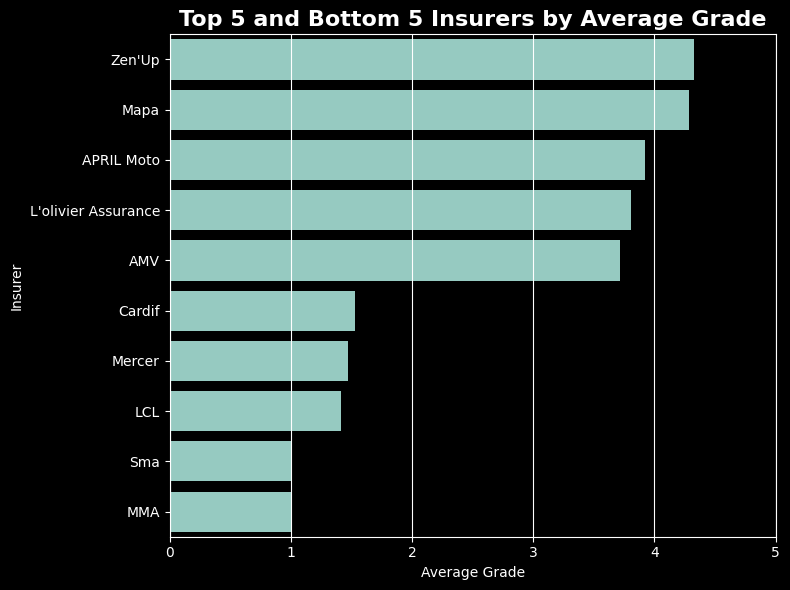

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'assureur' and calculate the mean of 'note'
average_grade_by_insurer = df.groupby('assureur', observed=True)['note'].mean().reset_index()

# Sort the data by the average grade for better visualization
average_grade_by_insurer = average_grade_by_insurer.sort_values(by='note', ascending=False)

# Select the top 5 and bottom 5 insurers
top_5 = average_grade_by_insurer.head(5)
bottom_5 = average_grade_by_insurer.tail(5)

# Combine the top 5 and bottom 5 insurers
selected_insurers = pd.concat([top_5, bottom_5])

# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='note', y='assureur', data=selected_insurers, order=selected_insurers['assureur'])
plt.title('Top 5 and Bottom 5 Insurers by Average Grade',fontsize=16, fontweight='bold')
plt.xlabel('Average Grade')
plt.ylabel('Insurer')
plt.xlim((0,5))
plt.grid(axis = "x")
plt.tight_layout()
plt.savefig("media/insurerstandings.png")
plt.show()

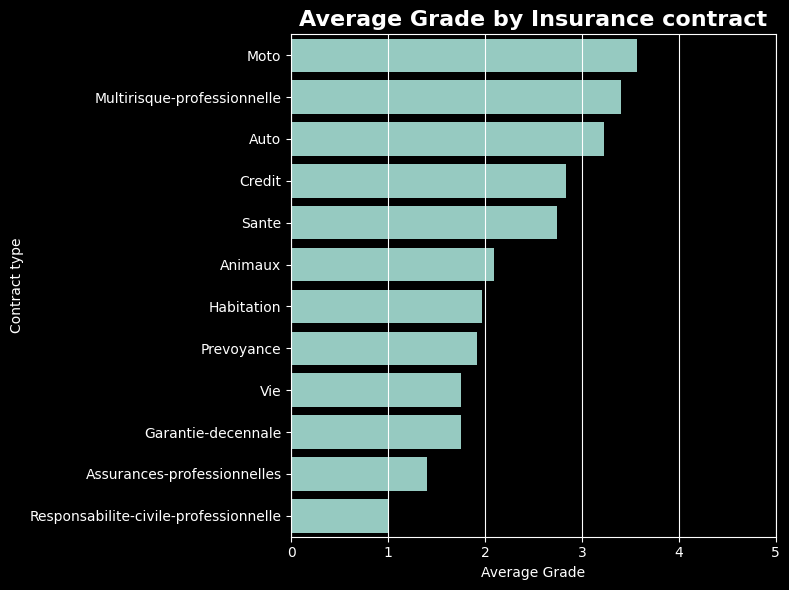

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'assureur' and calculate the mean of 'note'
average_grade_by_insurer = df.groupby('produit', observed=True)['note'].mean().reset_index()

# Sort the data by the average grade for better visualization
average_grade_by_insurer = average_grade_by_insurer.sort_values(by='note', ascending=False)

# Plotting using seaborn
plt.figure(figsize=(8,6))
sns.barplot(x='note', y='produit', data=average_grade_by_insurer, order=average_grade_by_insurer['produit'])
plt.title('Average Grade by Insurance contract',fontsize=16, fontweight='bold')
plt.xlabel('Average Grade')
plt.xlim((0,5))
plt.grid(axis = "x")
plt.ylabel('Contract type')
plt.tight_layout()
plt.savefig("media/averagegrade.png")
plt.show()

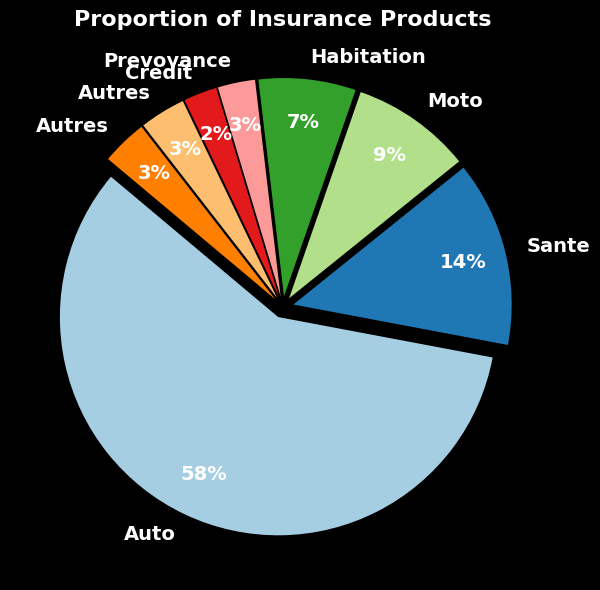

In [38]:
# Calculate the count and proportion of each product
product_counts = df['produit'].value_counts()
product_proportions = product_counts / product_counts.sum() * 100

# Categorize products with less than 2% as 'Autre'
product_proportions['Autres'] = product_proportions[product_proportions < 2].sum()

# Filter out products that have less than 2% and create a new Series
filtered_product_proportions = product_proportions[product_proportions >= 2]

# Combine the 'autres' category
final_product_proportions = pd.concat([filtered_product_proportions, pd.Series({'Autres': product_proportions['Autres']})])

# Plot the pie chart
plt.figure(figsize=(10,6))
plt.pie(final_product_proportions, labels=final_product_proportions.index,
        textprops={'weight': 'bold', 'size': 14},
          autopct='%1.0f%%', startangle=140,pctdistance = 0.8, colors=plt.cm.Paired.colors,explode=[0.05 for _ in range(len(final_product_proportions))])
plt.title('Proportion of Insurance Products',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("media/pie.png")
plt.show()

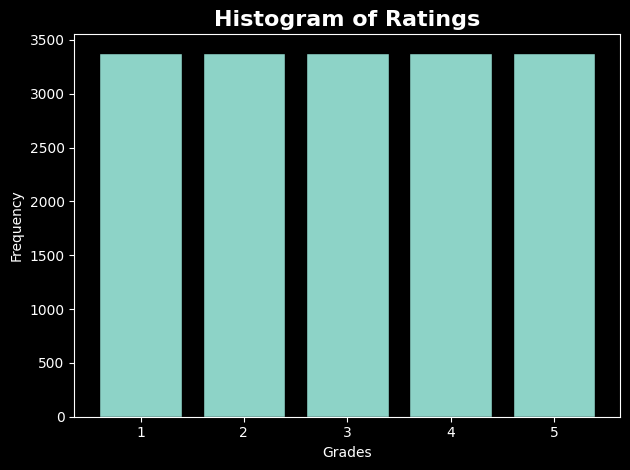

In [39]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(df['note'], bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
plt.xlabel('Grades')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings',fontsize=16, fontweight='bold')
plt.xticks(range(1, 6))  # Ensure labels match discrete categories
plt.tight_layout()
plt.savefig("media/histogram.png")
plt.show()

In [40]:
# Drop useless columns 
df.drop(["avis","date_exp","date_publication", "assureur"], axis=1, inplace= True)

# Rename columns
df.rename(columns={"avis_en": "text", "note": "rating", "produit": "product"}, inplace=True)

In [41]:
df.head()

,product,text,rating
18758,Sante,"Hello, Despite my complaints from Santiane, fo...",1.0
27460,Auto,"Hey Over the past 2 years, we have used MAIF's...",1.0
17433,Credit,Credit insurance that does not cover anything ...,1.0
18764,Prevoyance,"Hello, As it is impossible to continue the dis...",1.0
30679,Sante,"I was at the MGEN for more than 30 years, my o...",1.0


## Initial conclusions

s

## Export the cleaned dataset

In [42]:
df.to_csv("data/cleaned_data.csv")